In [84]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [17]:
import pandas_datareader as pdr

In [23]:
from datetime import datetime
import os

In [31]:
tech_list = ["AAPL","GOOG","MSFT","AMZN"]

#直近１年間のデータを出すための日付データ
end = datetime.now()
start = datetime(end.year - 1 , end.month,end.day)

# それぞれの名前でDataFrameを作ります。
for stock in tech_list:
    globals()[stock] = DataReader(stock,'yahoo',start,end)

AAPL.describe()

,High,Low,Open,Close,Volume,Adj Close
count,250.000000,250.000000,250.000000,250.000000,2.500000e+02,250.000000
mean,193.887080,189.869880,191.864680,191.913640,3.220006e+07,190.577102
std,20.835436,20.621645,20.721531,20.702576,1.348447e+07,20.899082
min,145.720001,142.000000,143.979996,142.190002,1.136200e+07,140.505798
25%,175.902496,173.362499,174.737499,174.757500,2.227930e+07,173.279305
50%,198.750000,193.805000,196.364998,196.345001,2.884945e+07,195.165611
75%,209.089996,205.104996,207.449997,207.479996,3.876678e+07,206.476418
max,228.220001,224.199997,225.639999,227.009995,9.574460e+07,227.009995


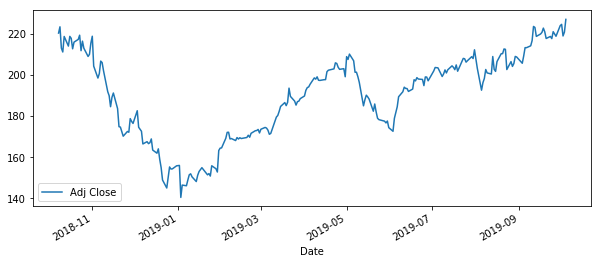

In [34]:
AAPL["Adj Close"].plot(legend="True",figsize=(10,4))

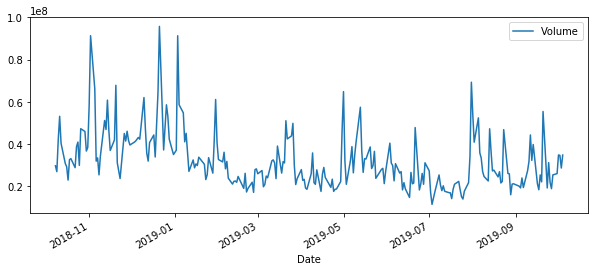

In [36]:
AAPL["Volume"].plot(legend=True,figsize=(10,4))

In [45]:
#移動平均線を描画
ma_day = [10,20,50]

for ma in ma_day:
    column_name = "MA{}".format(str(ma))
    AAPL[column_name] = AAPL["Adj Close"].rolling(window=ma).mean()

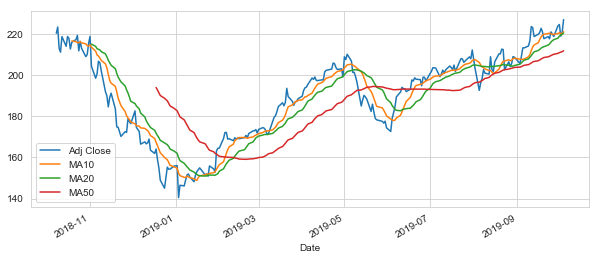

In [51]:
AAPL[["Adj Close","MA10","MA20","MA50"]].plot(figsize=(10,4))

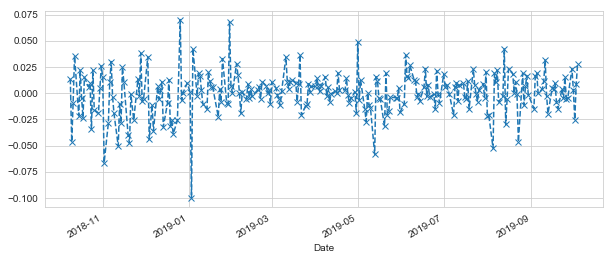

In [58]:
#デイリーの変化
AAPL["Daily Return"] = AAPL["Adj Close"].pct_change()
AAPL["Daily Return"].plot(linestyle="--",marker="x",figsize=(10,4))

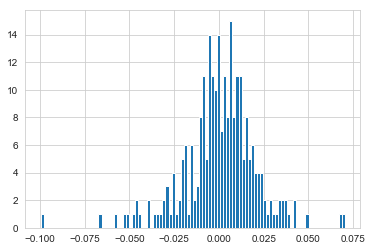

In [61]:
#ヒストグラムを作成
AAPL["Daily Return"].hist(bins=100)

In [65]:
closing_df = DataReader(['AAPL','GOOG','MSFT','AMZN'],'yahoo',start,end)['Adj Close']

In [66]:
tech_rets = closing_df.pct_change()

/Users/shin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


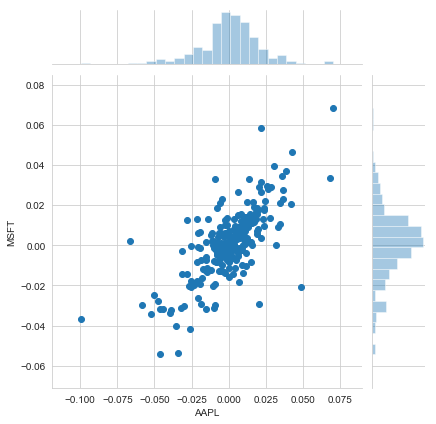

In [68]:
sns.jointplot("AAPL","MSFT",tech_rets,kind="scatter")

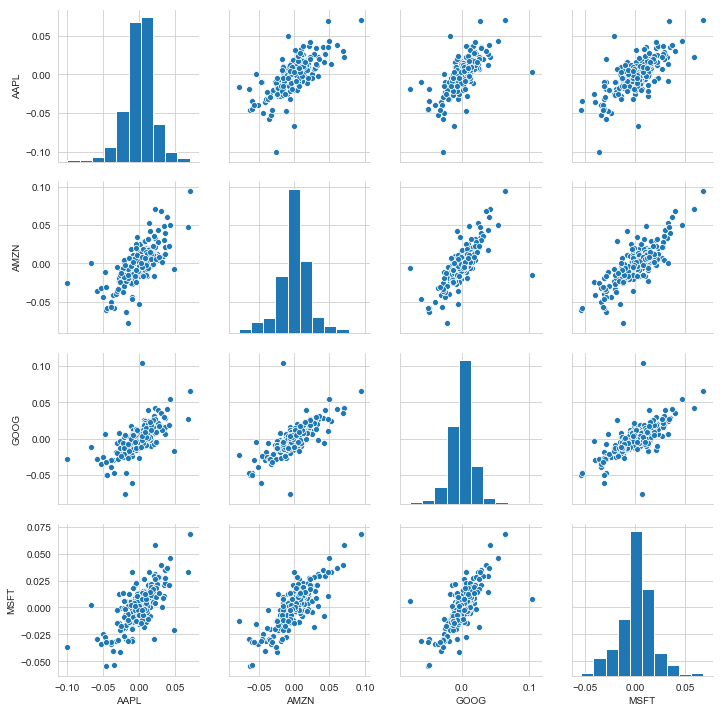

In [70]:
sns.pairplot(tech_rets.dropna())

/Users/shin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


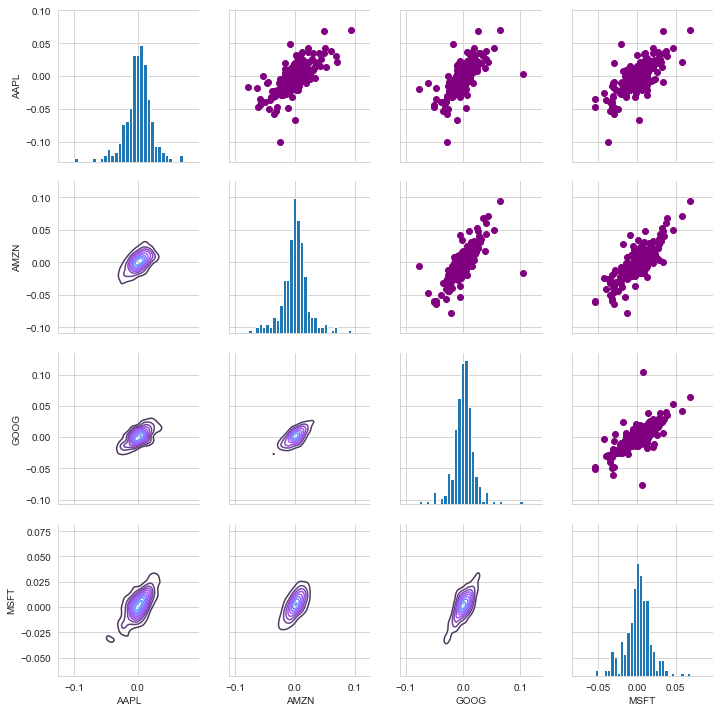

In [71]:
#PairGritを作成
returns_fig = sns.PairGrid(tech_rets.dropna())

#右上のグラフを指定
returns_fig.map_upper(plt.scatter,color="purple")

#左下のグラフを指定
returns_fig.map_lower(sns.kdeplot,cmap="cool_d")

#対角線のグラフを指定
returns_fig.map_diag(plt.hist,bins=30)

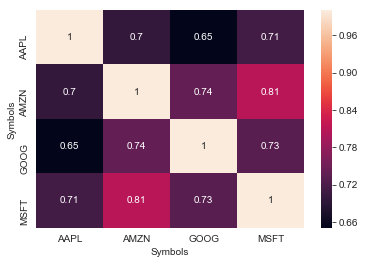

In [72]:
#相関係数を表示
sns.heatmap(tech_rets.corr(),annot=True)

In [73]:
rets = tech_rets.dropna()

In [74]:
rets.head()

Symbols,AAPL,AMZN,GOOG,MSFT
Date,,,,
2018-10-09,0.013853,0.003164,-0.008834,0.012720
2018-10-10,-0.046326,-0.061524,-0.050579,-0.054338
2018-10-11,-0.008828,-0.020447,-0.001757,-0.002355
2018-10-12,0.035719,0.040277,0.028499,0.034558
2018-10-15,-0.021386,-0.015465,-0.016062,-0.017979


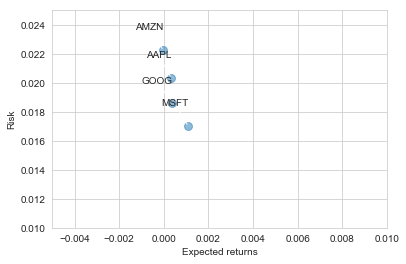

In [81]:
plt.scatter(rets.mean(),rets.std(),alpha=0.5,s=np.pi*20)
plt.ylim([0.01,0.025])
plt.xlim([-0.005,0.01])

plt.xlabel("Expected returns")
plt.ylabel("Risk")

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (0, 20),
        textcoords = 'offset points', ha = 'right',
        arrowprops = dict(arrowstyle='-', connectionstyle= 'arc3'))

/Users/shin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


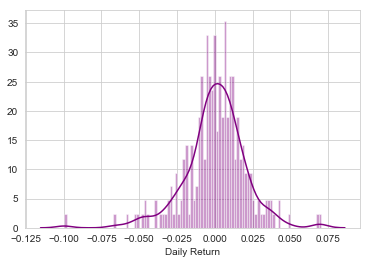

In [86]:
sns.distplot(AAPL['Daily Return'].dropna(),bins=100,color='purple')

In [87]:
# 5パーセンタイルの位置にある変動率は？
rets['AAPL'].quantile(0.05)

-0.03338004151865108

In [88]:
#1年を基準とする
days = 365

#1日分の差分
dt = 1/days

#日々の変動の平均を計算
mu = rets.mean()["GOOG"]

#ボラティリティを変動の標準偏差で計算
sigma = rets.std()["GOOG"]

In [91]:
def stock_monte_carlo(start_price,days,mu,sigma):
    
    #戻り値となる価格のリストを返す
    price = np.zeros(days)
    price[0] = start_price
    
    #ShockとDrift
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    #指定された日数のところまで計算
    for x in range(1,days):
        #shockを計算
        shock[x] = np.random.normal(loc=mu * dt,scale=sigma * np.sqrt(dt))
        #Driftを計算
        drift[x] = mu * dt
        #価格を計算
        price[x] = price[x-1] + (price[x-1]*(drift[x] + shock[x]))
    return price

In [92]:
GOOG.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-10-08,1168.000000,1127.364014,1150.109985,1148.969971,1932400,1148.969971
2018-10-09,1154.349976,1137.572021,1146.150024,1138.819946,1308700,1138.819946
2018-10-10,1132.170044,1081.130005,1131.079956,1081.219971,2675700,1081.219971
2018-10-11,1106.400024,1068.270020,1072.939941,1079.319946,2949000,1079.319946
2018-10-12,1115.000000,1086.401978,1108.000000,1110.079956,2101300,1110.079956


In [93]:
GOOG.iloc[0,5]

1148.969970703125

Text(0.5, 1.0, 'Monte Carlo Analysis for Google')

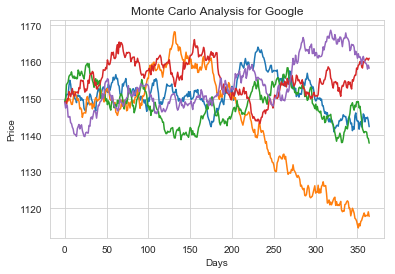

In [97]:
#最初の終値から開始
start_price = GOOG.iloc[0,5]

for run in range(5):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))

plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Monte Carlo Analysis for Google")

In [108]:
#回数を指定
runs = 10000

#結果を保持するarray
simulations = np.zeros(runs)

#表示オプション
np.set_printoptions(threshold=5)

for run in range(runs):
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1]

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([1065.70253958, 1066.55619468, 1067.40984977, ..., 1234.72624808,
        1235.57990318, 1236.43355827]),
 <a list of 200 Patch objects>)

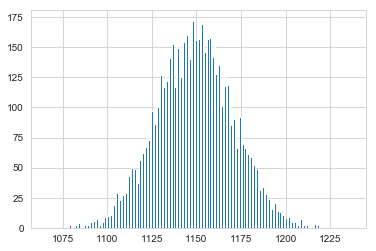

In [101]:
plt.hist(simulations,bins=200)

In [106]:
#1パーセントタイルの位置を設定
q = np.percentile(simulations,1)

Text(0.5, 1.0, 'Final price distribution for Google Stock after 365 days')

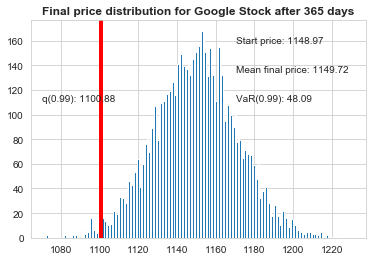

In [111]:
# 最終的な株価のヒストグラムを表示します。
plt.hist(simulations,bins=200)

#1パーセントタイルの位置を設定
q = np.percentile(simulations,1)

#最初の株価
plt.figtext(0.6,0.8,s="Start price: {:0.2f}".format(start_price))

#最終的な株価の平均値
plt.figtext(0.6,0.7,"Mean final price: {:0.2f}".format(simulations.mean()))

#Value at Risk（信頼区間99%）
plt.figtext(0.6,0.6,"VaR(0.99): {:0.2f}".format(start_price -q))

#1パーセントタイル
plt.figtext(0.15,0.6,"q(0.99): {:0.2f}".format(q))

#1%クォンタイルに線を描く
plt.axvline(x=q,linewidth=4,color="r")

#タイトル
plt.title("Final price distribution for Google Stock after {} days".format(days), weight='bold')